# Setup

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 654 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.stats import norm
import matplotlib.ticker as mtick

# Option Pricing

An option is a financial instrument called a derivative, that is, its value is based upon an underlying security, such as a stock.

Merely because of this, the value of an option is synchronized with the price of the stock. Thus, if you are aware of the market game, we cannot estimate the price.

If we are consistent with the definition of the returns of a stock to be a stochastic process, we encounter the problem of giving this derivative its price, since we do not know the path the underlying will follow.

This is where mathematicians came into place and used advanced stochastic calculus and computational methods. Today we are going to see 2 of the most common technics used in practice: Monte Carlo Simulation & Black-Scholes formula.

In this investigation, we will only price European options, in other words, options that can only be executed at the expiration date.

# Monte Carlo Simulations

Monte Carlo simulations are an alternative to solve probabilistic problems by numerically simulating various possible scenarios in order to calculate the statistical properties of the results, such as: expectation, and variance.
In the case of financial derivatives, this gives us a useful way to approximate the price of complex derivatives for which no analytical theory can be formulated.

## Brownian Motion

In the present work, the geometric brownian movement is analyzed and applied to the underlying asset in order to find the possible paths that it can take and weigh them.

The model assumes that risk is neutral and that all profit opportunities above the market have been taken (there is no arbitrage).

In this section of this work, a code will be written to be able to generate the valuation of assets through Monte Carlo simulations. The chosen will be: AAPL; although the methodology can be the same for any asset by changing the ticker.

## Monte Carlo applied to finance

As a tool, it can help solve the following financial problems:

> Descriptive statistics applied to portfolios:
* Expected returns
* Risk measures: VaR and CVaR
* Downside risk
* Decision trees for abnormal events

> To be able to value options with neutral risk and markets without arbitration.

This last application is the one that concerns us in the present work.











## Code

In [77]:
# Choose the Asset
ticker = "AAPL"

In [78]:
# Parameters for YFinance to download the data
asset = ticker
end_date = "2020-01-01"
start_date = "2015-01-01"

In [79]:
# Download the Data
price = yf.download(tickers = asset, start = start_date, end = end_date, adjusted=True)['Adj Close']

# Check the data
price.head()

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02    24.603201
2015-01-05    23.910097
2015-01-06    23.912342
2015-01-07    24.247646
2015-01-08    25.179296
Name: Adj Close, dtype: float64

In [80]:
# Maximum value of the price in the timespan
max_cap = price.idxmax()
print("Máximo: ", max_cap)

# Minimum value of the price in the timespan
min_cap = price.idxmin()
print("Mínimo: ", min_cap)

Máximo:  2019-12-31 00:00:00
Mínimo:  2016-05-12 00:00:00


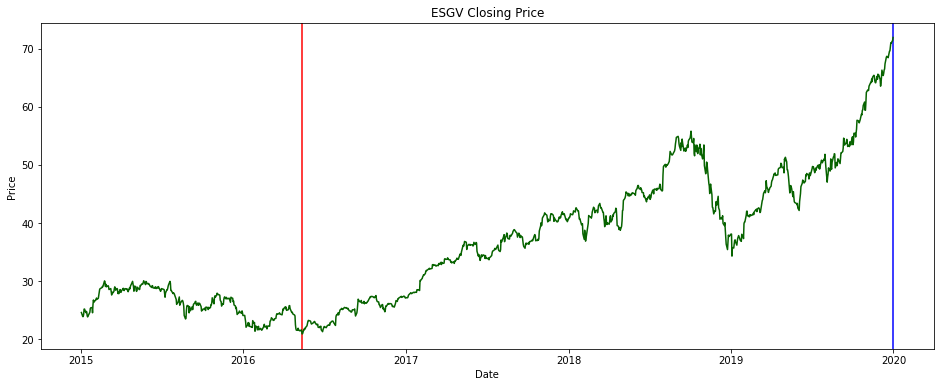

In [81]:
# Graph of the asset price
plt.figure(figsize=(16,6))
plt.ylabel("Price")
plt.xlabel("Date")
plt.title("ESGV Closing Price")

# Añadiendo max y min
plt.axvline(x=max_cap, color="blue")
plt.axvline(x=min_cap, color="red")

sns.lineplot(data=price, color="#076300")

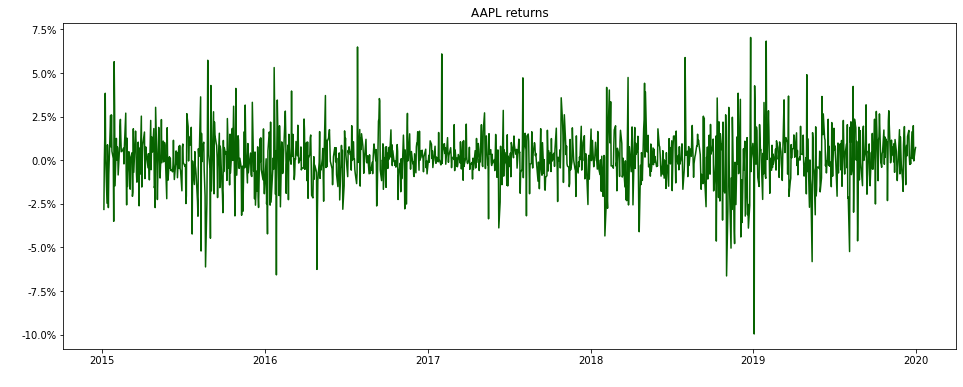

In [82]:
# Calculating the percentage returns
returns = price.pct_change().dropna()

# Graph of the returns
plt.figure(figsize=(16,6))
plt.ylabel(" ")
plt.xlabel(" ")
plt.title(f"{ticker} returns")
g1 = sns.lineplot(data=returns, color="#076300")
g1.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [83]:
# Checking the descriptive stats of the returns
descriptive_stats = pd.DataFrame(returns.describe())
descriptive_stats

,Adj Close
count,1257.000000
mean,0.000976
std,0.015646
min,-0.099607
25%,-0.005856
50%,0.000893
75%,0.008918
max,0.070422


In [84]:
dt.datetime.strptime(end_date, '%Y-%m-%d')

datetime.datetime(2020, 1, 1, 0, 0)

In [85]:
# Training data
train_start_date = start_date
train_end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')-dt.timedelta(126)               # 126 trading days (half a year)
train = returns[train_start_date:train_end_date]

#Testing data
test_start_date = train_end_date+dt.timedelta(1)
test_end_date = end_date
test = returns[test_start_date:test_end_date]

In [161]:
# Compute the statistics based upon the training data
mu = train.mean()
var = train.var()
sigma = train.std() 

In [87]:
# Define the Monte Carlo Simulation function modeling an stochastic process
def MC_sims(s_0, mu, sigma, n_sims, T, N):
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    return S_t

In [160]:
# Parameters of the simulation
T = len(test)-1
N = len(test)-1
s_0 = price[str(test.index[0].date())]
n_sims = 10**2                                     #100 simulations
mu
sigma
parameters = [s_0, mu, sigma, n_sims, T, N]

# Run the simulation
random_walks = MC_sims(*parameters)

In [89]:
random_walks = np.transpose(random_walks)

In [90]:
random_walks = pd.DataFrame(random_walks)
random_walks = random_walks.set_index(test.index)
random_walks.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-29,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,...,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376,51.037376
2019-08-30,51.904122,51.328670,52.755942,51.019370,52.168776,51.211808,51.400548,51.053019,50.353757,50.298753,...,49.940982,50.584853,49.278756,50.687555,51.037286,51.352164,50.151762,49.759549,51.932576,50.650326
2019-09-03,52.498272,51.431017,53.123004,50.892320,51.847512,51.033885,53.844058,50.942769,49.995977,50.569938,...,49.823657,50.850849,49.579541,50.843955,51.464851,50.928742,50.953549,50.066904,51.127239,51.418759
2019-09-04,52.471662,50.830588,53.250771,50.873339,51.797423,50.464353,53.569650,50.140960,50.215022,50.268593,...,50.083357,51.083829,50.670444,50.753709,52.937263,50.440945,51.082734,49.556052,50.840909,49.668699
2019-09-05,51.991540,51.119878,52.849463,49.919559,51.222677,49.618799,52.496766,50.605356,50.515681,49.462979,...,49.637917,50.408130,48.950241,50.353449,52.856569,48.985146,51.204923,49.216628,49.444264,49.223370


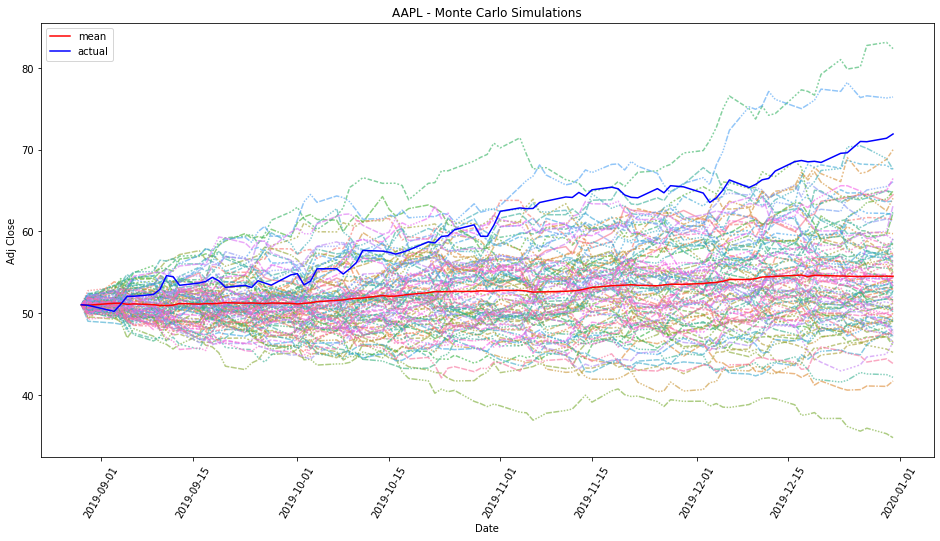

In [91]:
# Graph of the Monte Carlo simulations
plt.figure(figsize=(16,8))
plt.title(f"{ticker} - Monte Carlo Simulations")
plt.xticks(rotation=60)
plt.xlabel("Date")
all = sns.lineplot(data=random_walks, legend = False, alpha = 0.6)
line_mean = sns.lineplot(data=random_walks.mean(axis=1), color = "red", label = "mean")
linea_actual = sns.lineplot(data=price[test_start_date:test_end_date], color = "blue", label = "actual")

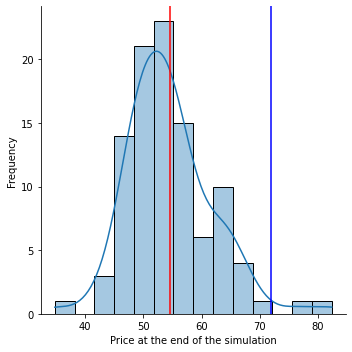

In [92]:
sns.displot(data = random_walks.iloc[-1], alpha=0.4, kde=True)
plt.xlabel("Price at the end of the simulation")
plt.ylabel("Frequency")
plt.axvline(x=price[-1], color="blue")
plt.axvline(x=random_walks.iloc[-1].mean(), color="red")

## Conclusion

As you might have noticed, the mean estimated value deviated quite substantially from the real price. This happens mostly because we assumed a normal distribution of the returns, which is not the case for stock returns. Additionally, we just specified a statistical behavior on the random walk, but there are a lot of factors that can influence the price.

To make things short, we didn't know the real mean of the futures prices because of poor assumptions. Let's see what happens if we are time travelers and already know what the future expected return will be.

In [93]:
T = len(test)-1
N = len(test)-1
s_0 = price[str(test.index[0].date())]
n_sims = 10**2                                     #100 simulations
mu = test.mean()                                   #future mean
sigma = test.std()                                 #future risk
parameters = [s_0, mu, sigma, n_sims, T, N]

random_walks = MC_sims(*parameters)
random_walks = np.transpose(random_walks)
random_walks = pd.DataFrame(random_walks)
random_walks = random_walks.set_index(test.index)

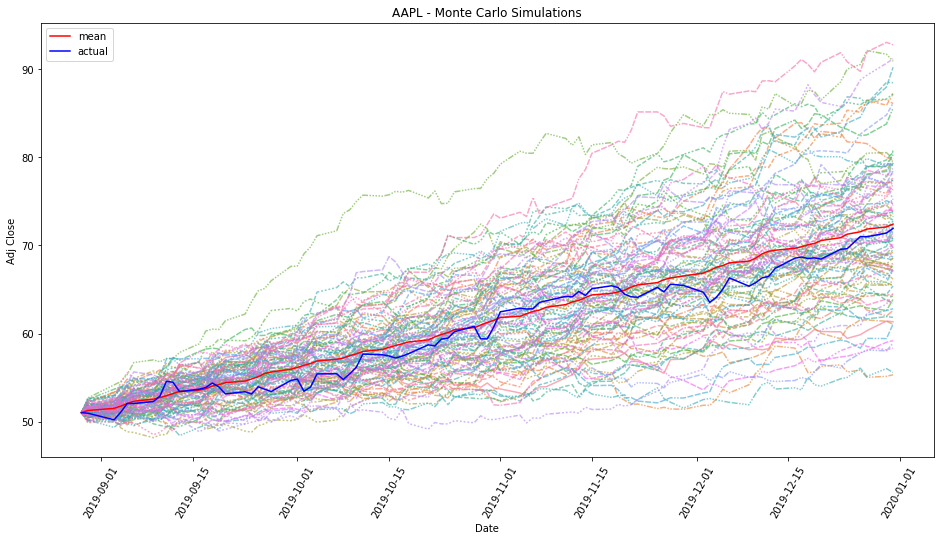

In [94]:
# Graph of the Monte Carlo simulations (time traveler)
plt.figure(figsize=(16,8))
plt.title(f"{ticker} - Monte Carlo Simulations")
plt.xticks(rotation=60)
plt.xlabel("Date")
all = sns.lineplot(data=random_walks, legend = False, alpha = 0.6)
line_mean = sns.lineplot(data=random_walks.mean(axis=1), color = "red", label = "mean")
linea_actual = sns.lineplot(data=price[test_start_date:test_end_date], color = "blue", label = "actual")

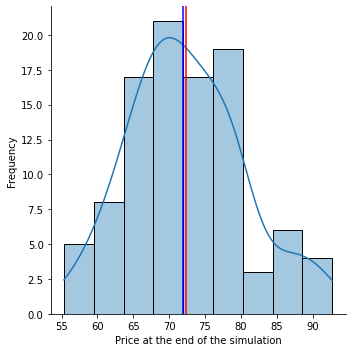

In [95]:
sns.displot(data = random_walks.iloc[-1], alpha=0.4, kde=True)
plt.xlabel("Price at the end of the simulation")
plt.ylabel("Frequency")
plt.axvline(x=price[-1], color="blue")
plt.axvline(x=random_walks.iloc[-1].mean(), color="red")

You will notice that if we do a better analysis, we can get better results and price and option correctly using MC simulations.

# Black Scholes Model

Black Scholes model is a mathematical model for dynamic time series that assumes too that stock returns follow a random walk. This formula was obtained through stochastic calculus and was awarded a Nobel Price, but we are only reviewing its Python implementation.

In this example we will use the same parameters for the call and the put.

## Defining the model

In [345]:
# Definimos el modelo Black Scholes:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    d1 = (np.log(S_0/K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = (np.log(S_0/K) + (r - 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    if type == 'call':
        val = (S_0*norm.cdf(d1, 0, 1)-K*np.exp(-r*T)*norm.cdf(d2, 0, 1))
    if type == 'put':
        val = (K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)-S_0*norm.cdf(-d1, 0, 1))
    return val

In [414]:
# Parameters
S_0 = price[str(test.index[0].date())]                  ## initial price
K = 60                                                  ## strike
r = 0.04                                                ## anual risk-free rate
T = 0.5                                                 ## time until maturity in years
sigma = test.std()*(T*252)**(1/2)                       ## underlying stock volatility (annualized)

N = 126                                                 ## number of time increments for simulations
dt = T / N                                              ## time step            
discount_factor = np.exp(-r * T)                        ## discount factor, which is used to calculate the present value of the future payoff

## Call Option

In [433]:
"""
Calculating the price of the call option with Black Scholes
"""
# Using the formula
parameters = [s_0, K, T, r, sigma]
call_option = black_scholes_analytical(*parameters, type='call')
call_option

0.1421904880490601

In [436]:
"""
Calculating the price of the call option with MC simulation
"""

# Simulating the paths
n_sims = 10**5
gbm_sims = MC_sims(s_0=S_0, mu = r, sigma = sigma, n_sims=n_sims, T=T, N=N)
# Calculating the option premium (risk neutral) por simulaciones de MC
premium = discount_factor * np.average(np.maximum(0,gbm_sims[:, -1] - K))
premium

0.14209533056213108

The price of the call option calculated with Monte Carlo (≈0.142) is close to the one calculated with Black Scholes (=0.142).

## Para una opción put

In [447]:
"""
Calculating the price of the put option with Black Scholes
"""
# Using the formula
parameters = [s_0, K, T, r, sigma]
put_option = black_scholes_analytical(*parameters, type='put')
put_option

7.916734482645779

In [451]:
"""
Calculating the price of the put option with MC simulation
"""

# Simulating the paths
n_sims = 10**5
gbm_sims = MC_sims(s_0=S_0, mu=r, sigma=sigma,n_sims=n_sims, T=T, N=N)
# Calculating the option premium (risk neutral) por simulaciones de MC
premium = discount_factor * np.average(np.maximum(0,K-gbm_sims[:, -1]))
premium

7.912149602293192

The price of the call option calculated with Monte Carlo (≈7.91) is close to the one calculated with Black Scholes (=7.91).